In [6]:
import math
from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [7]:
from vecbool_data_gen import *

In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
X_train, y_train = get_train_data(1000)

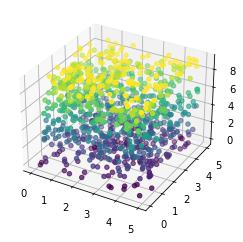

In [41]:
ax = plt.axes(projection='3d')
ax.scatter3D(X_train[:, 0], X_train[:, 1], y_train, c=y_train)

In [6]:
get_rotation_amount([1,0,0,1])

5

In [48]:
print(type(test))
np.apply_along_axis(b, 1, get_rotation_amount)


<class 'numpy.ndarray'>


AxisError: axis 1 is out of bounds for array of dimension 0

In [32]:
test.ndim

2

In [37]:
get_rotation_amount(test.T)

array([1, 7, 3, 7, 7])